In [2]:
import pyart
from matplotlib import pyplot as plt
import cartopy
from boto.s3.connection import S3Connection
import datetime
import tempfile
import numpy as np
import xarray
import netCDF4 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pytz

%matplotlib inline

In [3]:
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    print(keys[index])
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [46]:
# Lets grab the latest radar volume from Seattle
station = 'KLOT'
my_datetime = datetime.datetime(2017,12,5, 1, 0)
klot = get_radar_from_aws('KLOT', my_datetime)
kilx = get_radar_from_aws('KILX', my_datetime)
kdvn = get_radar_from_aws('KDVN', my_datetime)



<Key: noaa-nexrad-level2,2017/12/05/KLOT/KLOT20171205_005642_V06>
<Key: noaa-nexrad-level2,2017/12/05/KILX/KILX20171205_010112_V06>
<Key: noaa-nexrad-level2,2017/12/05/KDVN/KDVN20171205_005845_V06>


In [47]:
sweep = 0
index_at_start = klot.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = netCDF4.num2date(klot.time['data'][index_at_start], 
                                  klot.time['units'])
pacific = pytz.timezone('US/Central')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

Monday December 04 at 06:56 PM CST


In [48]:
strfmt = my_datetime.strftime('%Y%m%d_%H%M')

In [49]:
speckles_kdvn = pyart.correct.despeckle.despeckle_field(kdvn, 'reflectivity')
speckles_kilx = pyart.correct.despeckle.despeckle_field(kilx, 'reflectivity')
speckles_klot = pyart.correct.despeckle.despeckle_field(klot, 'reflectivity')


In [50]:
grids = pyart.map.grid_from_radars((klot, kilx, kdvn),(1,801,801),
                   ((1000.,1001.),(-200000.,200000.),(-600000.,200000.)),
                   fields=['reflectivity'],
                   refl_field='reflectivity', 
                   gatefilters=(speckles_klot, speckles_kilx, 
                                speckles_kdvn))

In [51]:
long, lat = grids.get_point_longitude_latitude()
height = grids.point_z['data'][:,0,0]
time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])
ds = xarray.Dataset()
for this_field in list(grids.fields.keys()):
    this_data = grids.fields[this_field]['data']
    my_data = xarray.DataArray(np.ma.expand_dims(this_data,0),
                               dims = ('time', 'z', 'y', 'x'),
                               coords = {'time' : (['time'], time),
                                         'z' : (['z'], height),
                                         'lat' :(['y','x'], lat),
                                         'lon' : (['y','x'],long),
                                          'y' : (['y'],lat[:,0]),
                                          'x' : (['x'],long[0,:])})
    
    for this_meta in list(grids.fields[this_field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})
    
    ds[this_field] = my_data
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
             ('units', 'degrees_east')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
             ('units', 'degrees_north')]
    ds.z.attrs['long_name'] = "height above sea sea level"
    ds.z.attrs['units'] = "m"

    ds.z.encoding['_FillValue'] = None
    ds.lat.encoding['_FillValue'] = None
    ds.lon.encoding['_FillValue'] = None

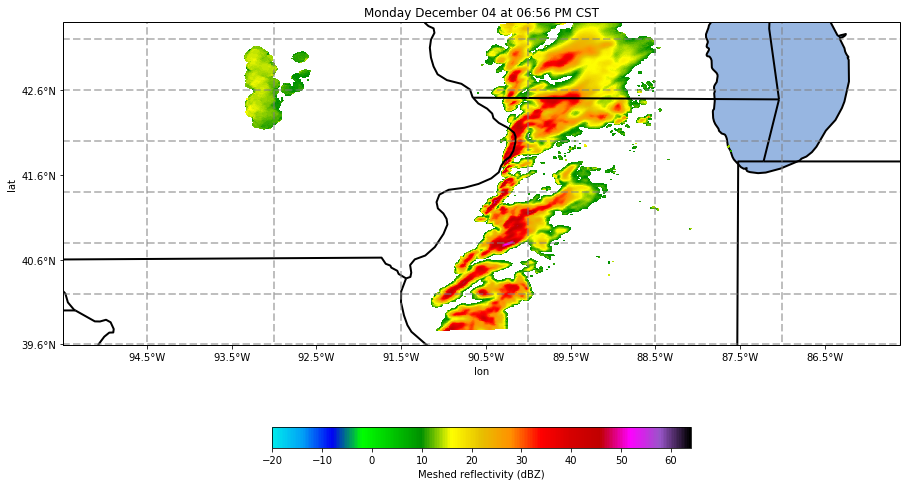

In [52]:
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                      ds.lat.max(), 1)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                      ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = ds.reflectivity[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed reflectivity (dBZ)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')